## Building a Predictive Model for Cereal Brand Ratings

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline

In [3]:
data = pd.read_csv('cereal.csv')
data.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


### Feature Engineering

Remember from our EDA that rating had pretty high negative correlation with calories and sugar and pretty high positive correlation with  protein and fiber. We want to create new features using these variables closely related to rating.

In [5]:
data['calories2'] = data['calories'] * 2
data['sugars2'] = data['sugars'] * 2
data['protein2'] = data['protein'] * 2
data['fiber2'] = data['fiber'] * 2

In our EDA, we saw that distribution of vitamins and weight had a huge spike in the middle and nearly flat values at both ends. This means there is not much of a difference in these variables for most cereal products and we are dropping them to reduce noise.

In [6]:
data.drop(['vitamins','weight'], axis=1, inplace=True)

Also, potassium and fiber had really high correlation, so we will drop the potassium variable to prevent overfitting.

In [7]:
data.drop(['potass'], axis=1, inplace=True)

Let's refer back to the visualizations of distributions in our EDA and actually calculate the skewedness of each variable. If some variables are extremely skewed, we will normalize then so that machine learning models will work better on them.

In [8]:
# (-) values mean left skewed, and (+) values mean right skewed
num_var = data.select_dtypes(exclude=['object']).columns.values.tolist()

data[num_var].apply(lambda x: skew(x))

calories    -0.436683
protein      0.731221
fat          1.143151
sodium      -0.564435
fiber        2.384046
carbo       -0.439156
sugars       0.033940
shelf       -0.402302
cups        -0.102924
rating       0.892412
calories2   -0.436683
sugars2      0.033940
protein2     0.731221
fiber2       2.384046
dtype: float64

For right skewed distribution, we take square / cube root or logarithm of variable and for left skewed, we take square / cube or exponential of variables.

In [10]:
data.loc[:, ['calories','sodium', 'carbo','shelf','calories2']] =\
np.sqrt(data.loc[:, ['calories','sodium', 'carbo','shelf','calories2']])

data.loc[:, ['protein','fat','fiber','protein2','fiber2']] =\
np.sqrt(data.loc[:, ['protein','fat','fiber','protein2','fiber2']])

C:\Users\Seungjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 17 columns):
name         77 non-null object
mfr          77 non-null object
type         77 non-null object
calories     77 non-null float64
protein      77 non-null float64
fat          77 non-null float64
sodium       77 non-null float64
fiber        77 non-null float64
carbo        76 non-null float64
sugars       77 non-null int64
shelf        77 non-null float64
cups         77 non-null float64
rating       77 non-null float64
calories2    77 non-null float64
sugars2      77 non-null int64
protein2     77 non-null float64
fiber2       77 non-null float64
dtypes: float64(12), int64(2), object(3)
memory usage: 10.3+ KB


In [16]:
data.carbo.isnull()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
      ...  
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57     True
58    False
59    False
60    False
61    False
62    False
63    False
64    False
65    False
66    False
67    False
68    False
69    False
70    False
71    False
72    False
73    False
74    False
75    False
76    False
Name: carbo, Length: 77, dtype: bool

In [18]:
data = data.drop(data.index[57])

### Encoding Categorical Data

In [19]:
data = pd.get_dummies(data, columns=['mfr', 'type'])

### Splitting into Training and Testing Data¶

In [20]:
data.columns.values

array(['name', 'calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo',
       'sugars', 'shelf', 'cups', 'rating', 'calories2', 'sugars2',
       'protein2', 'fiber2', 'mfr_A', 'mfr_G', 'mfr_K', 'mfr_N', 'mfr_P',
       'mfr_Q', 'mfr_R', 'type_C', 'type_H'], dtype=object)

In [21]:
data.set_index('name', inplace=True)

In [22]:
Y = data.loc[:, ['rating']]
X = data.drop(['rating'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=42)

In [23]:
print("X_train : " + str(type(X_train)) + str(X_train.shape))
print("X_test : " + str(type(X_test)) + str(X_test.shape))
print("Y_train : " + str(type(Y_train)) + str(Y_train.shape))
print("Y_test : " + str(type(Y_test)) + str(Y_test.shape))

X_train : <class 'pandas.core.frame.DataFrame'>(53, 22)
X_test : <class 'pandas.core.frame.DataFrame'>(23, 22)
Y_train : <class 'pandas.core.frame.DataFrame'>(53, 1)
Y_test : <class 'pandas.core.frame.DataFrame'>(23, 1)


### Regression Model Evaluation Metric

We will use RMSE to build a predictive regression model for cereal product ratings

In [24]:
# Define error measure for official scoring : RMSE

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= (np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = scorer))).mean()
    return(rmse)

def rmse_cv_test(model):
    rmse= (np.sqrt(-cross_val_score(model, X_test, Y_test, scoring = scorer))).mean()
    return(rmse)

### Linear Regression

In [25]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Look at predictions on training and test set
print("RMSE on Training set :", rmse_cv_train(lr_model))
print("RMSE on Test set :", rmse_cv_test(lr_model))

RMSE on Training set : 3.99547176014
RMSE on Test set : 17.1268808116


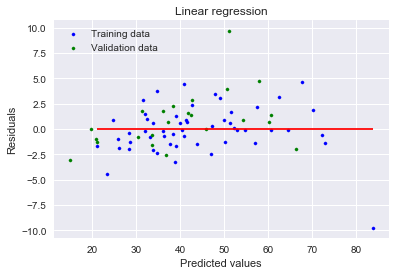

In [28]:
# Plot residuals
plt.scatter(lr_model.predict(X_train), lr_model.predict(X_train) - Y_train, c = "blue", label = "Training data", s=10)
plt.scatter(lr_model.predict(X_test), lr_model.predict(X_test) - Y_test, c = "green", label = "Validation data", s=10)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = min(lr_model.predict(X_train)), xmax = max(lr_model.predict(X_train)), color = "red")

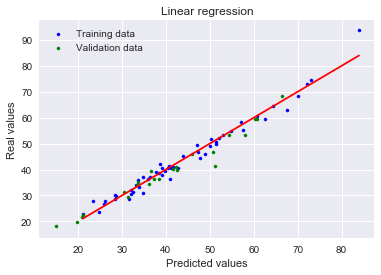

In [29]:
# Plot predictions
plt.scatter(lr_model.predict(X_train), Y_train, c = "blue", label = "Training data", s=10)
plt.scatter(lr_model.predict(X_test), Y_test, c = "green", label = "Validation data", s=10)

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")

plt.plot([min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], 
         [min(lr_model.predict(X_train)), max(lr_model.predict(X_train))], c='red')

### Random Forest

In [30]:
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest.fit(X_train, Y_train)

print("RandomForestRegressor RMSE on Training set :", rmse_cv_train(random_forest))
print("RandomForestRegressor RMSE on Test set :", rmse_cv_test(random_forest))

C:\Users\Seungjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RandomForestRegressor RMSE on Training set : 7.17568870227


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


RandomForestRegressor RMSE on Test set : 6.03030589317


### Support Vector Machine

In [31]:
from sklearn.svm import SVR


svr_rbf = SVR(kernel='rbf', gamma=0.1)
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly',degree=2)

In [32]:
svr_lin.fit(X_train, Y_train)
print("Linear SVR RMSE on Training set :", rmse_cv_train(svr_lin))
print("Linear SVR RMSE on Test set :", rmse_cv_test(svr_lin))

Lasso RMSE on Training set : 3.05428649253
Lasso RMSE on Test set : 5.76570240933


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [33]:
svr_poly.fit(X_train, Y_train)
print("Polynomial SVR RMSE on Training set :", rmse_cv_train(svr_poly))
print("Polynomial SVR RMSE on Test set :", rmse_cv_test(svr_poly))

Polynomial SVR RMSE on Training set : 3.71888207697
Polynomial SVR RMSE on Test set : 5.13449202643


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

### Ridge Regression

In [34]:
ridge = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 5, 10, 30, 60, 100], cv=10)

ridge.fit(X_train, Y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge))
print("Ridge RMSE on Test set :", rmse_cv_test(ridge))

Best alpha : 1
Ridge RMSE on Training set : 3.57965873406
Ridge RMSE on Test set : 4.74545592263


### Lasso Regression

In [35]:
lasso = LassoCV(alphas = [1e-4, 5e-4, 1e-3, 5e-3, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, Y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso))
print("Lasso RMSE on Test set :", rmse_cv_test(lasso))

C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha : 0.05


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso RMSE on Training set : 3.31620905586


C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Seungjun\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed whe

Lasso RMSE on Test set : 5.51441133149


Overall, linear regression model resulted in overfitting (Got RMSE of 3.9 for training set and RMSE of 17.1 for validation set) but other more complicated models seemed to have slightly higher RMSE for training set but way lower RMSE for validation set, signaling sound prediction. Ridge Regression model had RMSE of 3.5 and 4.7 for training and validation set, the best performance of all the models(Lasso, Support Vector Regression, Random Forest Regression, Linear Regression)